<a href="https://colab.research.google.com/github/limshaocong/analyticsEdge/blob/main/Data_Exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [68]:
# In case any of the packages can't load
install.packages("janitor")
install.packages("padr")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
library(tidyverse) # generic must have package
library(dplyr)
library(ggplot2) # plotting package
library(janitor) # use tablyr for pivot table like functions 
library(lubridate) # easy comprehension of dates from string to correct datetime format
library(padr) # use pad to fill in time series data with missing dates

options(repr.plot.width = 9,
        repr.plot.height = 6,
        repr.plot.pointsize = 20)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘janitor’


The following objects are masked from ‘package:stats’:

    chisq.test, fisher.test



Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




In [72]:
# Accessing all the files stored on the GitHub repository
#
# As Colab is primarily designed for Python, the proper way to integrate
# GitHub and Colab within the workflow doesn't work very well when we force
# Colab to run in R.
# 
# Hence, I'm using this method that is untidy but very stable

path = "https://raw.githubusercontent.com/limshaocong/analyticsEdge/main/Datasets/"

# Russell 3000 tickers
tickers.path = paste0(path,"r3000_tickers.csv")

# Quiver Quant data
twitter.follower.path = paste0(path, "QuiverQuant/twitter_follower.csv")
wiki.pageviews.path = paste0(path,"QuiverQuant/wikipedia_pageviews.csv")
wsb.sentiment.path = paste0(path,"QuiverQuant/wsb_sentiment.csv")
otc.path = paste0(path,"QuiverQuant/otc_20192021.csv")

# RavenPack Sentiment Relevance data
rp.company.index.path = paste0(path,"RavenPack_WRDS/rp_company_index.csv")
## Dow Jones new releases (2018-2021)
rp.dj.2018.path = paste0(path,"RavenPack_WRDS/rp_dj_2018.csv")
rp.dj.2019.path = paste0(path,"RavenPack_WRDS/rp_dj_2019.csv")
rp.dj.2020.path = paste0(path,"RavenPack_WRDS/rp_dj_2020.csv")
rp.dj.2021.path = paste0(path,"RavenPack_WRDS/rp_dj_2021.csv")
## Global Press releases (2018-2021)
rp.pr.2018.path = paste0(path,"RavenPack_WRDS/rp_pr_2018.csv")
rp.pr.2019.path = paste0(path,"RavenPack_WRDS/rp_pr_2019.csv")
rp.pr.2020.path = paste0(path,"RavenPack_WRDS/rp_pr_2020.csv")
rp.pr.2021.path = paste0(path,"RavenPack_WRDS/rp_pr_2021.csv")
## FAANG
RP.path = paste0(path,"RavenPack_WRDS/RP.csv")


# CRSP Stock Price data
crsp.permnocode.path = paste0(path,"CRSP_WRDS/crsp_permno.csv")
crsp.price.2019.path = paste0(path,"CRSP_WRDS/crsp_daily_stock_price_2019.csv")
crsp.price.2020.path = paste0(path,"CRSP_WRDS/crsp_daily_stock_price_2020.csv")
crsp.price.2021.path = paste0(path,"CRSP_WRDS/crsp_daily_stock_price_2021.csv")

# Tweets
twitter.sa.path1 = "Tweet_Analysis_Tagged/"
twitter.sa.path2 = "_tweets_2020_tagged.csv"

# **RavenPack Data**


* Index File file for Ravenpack Indentifier
*   Dow Jones News Release Sentiment (2018-2021)
* Global Press Release Sentiment (2018-2021)



In [109]:
# Import company index which allows the tickers to be mapped to RavenPack's
# internal entity index (rp_entity_id)
rp.company.index = read.csv(rp.company.index.path)

# Read the 2021 Dow Jones sentiment data
rp.dj.2021 = read.csv(rp.dj.2021.path)
# Convert to datetime format
rp.dj.2021$rpna_date_utc = mdy(rp.dj.2021$rpna_date_utc)

**Dow Jones + Global Press Release Sentiment**

*   Generally sparse data requires imputation
* Significant volume of ess = 50
*   Retaining relevance = 100 is sufficient, relevance = 20 can be omitted
* Should consider scaling due to odd range
* Also contains weekend data, need to regard how such data is managed



In [ ]:
# Sample of RavenPack Identifier dataset
#
# $rp_entitiy_id is the identifier for RavenPack data
# Our primary identified is $ticker

head(rp.company.index, 5)

,X,rp_entity_id,entity_type,entity_name,ticker,cusip,isin,country
,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,7,00067A,COMP,Humana Inc.,HUM,444859102,US4448591028,US
2,88,001F1B,COMP,PriceSmart Inc.,PSMT,741511109,US7415111092,US
3,120,002A99,COMP,FibroGen Inc.,FGEN,31572Q808,US31572Q8087,US
4,143,00326D,COMP,Park Aerospace Corp.,PKE,70014A104,US70014A1043,US
5,144,00326E,COMP,Meritor Inc.,MTOR,59001K100,US59001K1007,US


In [ ]:
# Sample of RavenPack Dow Jones dataset
# Sumamrises sentiment data by Dow Jones-affliated publications
#
# $rp_entitiy_id: identifier
# $ess: event sentiment score bounded [0-100], 50 = neutral, >50 = positive, <50 = negative
# $relevance: if the company is the topic of the publication, 100 = sole focus of the release, 1 = mentioned in passing

head(rp.dj.2021, 5)

,rp_entity_id,category,relevance,ess,rpna_date_utc
,<chr>,<chr>,<int>,<int>,<date>
1,036C6F,legal-issues-defendant,100,22,2021-01-01
2,315EB0,insider-gift,100,57,2021-01-01
3,579E8F,ownership-decrease-held,100,49,2021-01-01
4,693ECD,insider-surrender,100,37,2021-01-01
5,723548,dividend,100,50,2021-01-01


In [ ]:
# Only 2815/2958 stocks have any press release in 2021 dataset

length(unique(rp.dj.2021$rp_entity_id))

[1] 2815

In [ ]:
first = min(rp.dj.2021$rpna_date_utc)
last = max(rp.dj.2021$rpna_date_utc)
last - first
paste(first, ",", last)

Time difference of 272 days

[1] "2021-01-01 , 2021-09-30"

In [ ]:
# Sample of Stock level data - APPL
#
# Conclusions:
#
# 1. Data is relatively spares, with no data on most dates. Preprocess to
# fill in non-entries. (see intervals between dates)
#
# 2. There are several entries which share the same "category", "relevance",
# "ess" and "date". Preprocess to aggregate repetitions. (see rows 3-5)
#
# 3. There are also several entries on the same "date" that have a range of 
# "ess". Need to determine means of aggregation. (see Jan 6, row 8-10)
#

aapl.index = rp.company.index$rp_entity_id[rp.company.index$ticker == "AAPL"]

rp.dj.2021 %>%
  filter(rp.dj.2021$rp_entity_id == aapl.index) %>%
  head(25)

,rp_entity_id,category,relevance,ess,rpna_date_utc
,<chr>,<chr>,<int>,<int>,<date>
1,D8442A,analyst-ratings-change-neutral,100,51,2021-01-05
2,D8442A,price-target-upgrade,100,91,2021-01-05
3,D8442A,executive-appointment,100,54,2021-01-05
4,D8442A,executive-appointment,100,54,2021-01-05
5,D8442A,executive-appointment,100,54,2021-01-05
6,D8442A,analyst-ratings-change-neutral,100,78,2021-01-05
7,D8442A,price-target-upgrade,100,75,2021-01-05
8,D8442A,executive-salary-increase,100,44,2021-01-06
9,D8442A,executive-salary-increase,100,44,2021-01-06


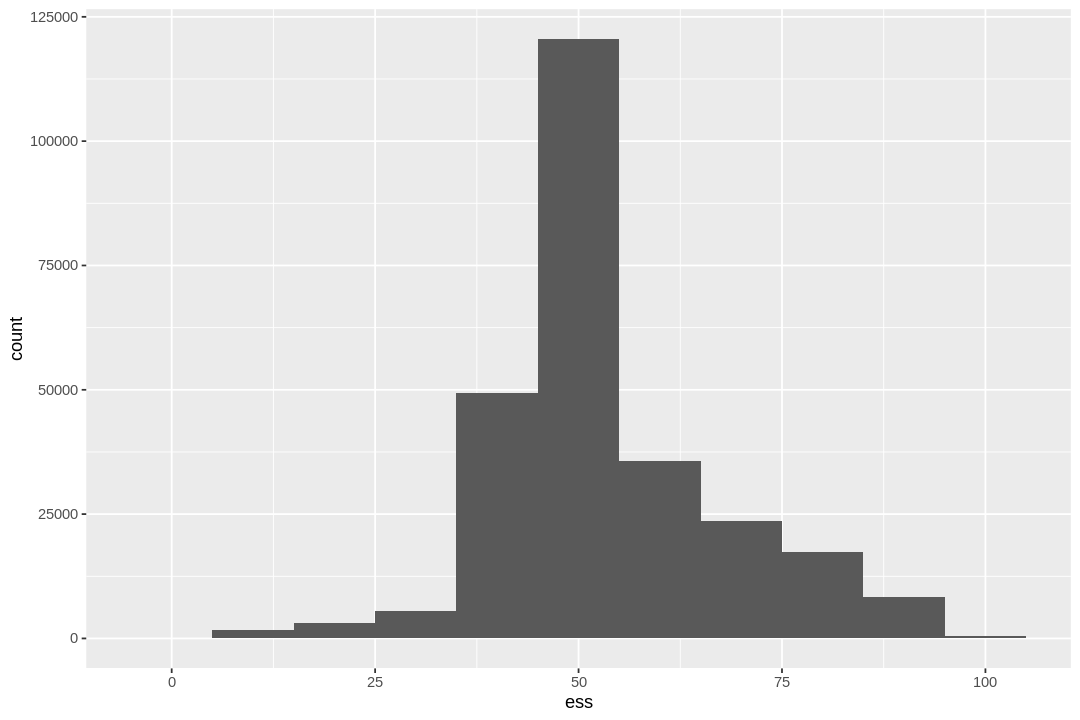

In [ ]:
# Plotting relative frequency of $ess

rp.dj.2021 %>%
  ggplot() +
  geom_histogram(aes(x = ess), binwidth = 10)

In [ ]:
# Following from the above, it is clear that majority of news release are neutral
# with a longer bias towards positive news
#
# Conclusion:
#
# 4. Many entries that have neutral sentiment (ie. ess = 50). Preprocessing
# needs to assume if absence of press release and neutral announcement should
# encoded the same.

rp.dj.2021 %>%
  tabyl(ess) %>%
  adorn_pct_formatting(digits = 2, affix_sign = TRUE) %>%
  arrange(desc(n)) %>% head(10)

,ess,n,percent
,<int>,<dbl>,<chr>
1,50,100179,37.67%
2,40,28903,10.87%
3,61,19855,7.47%
4,69,16805,6.32%
5,37,15529,5.84%
6,78,10144,3.81%
7,54,8050,3.03%
8,63,5770,2.17%
9,51,4329,1.63%


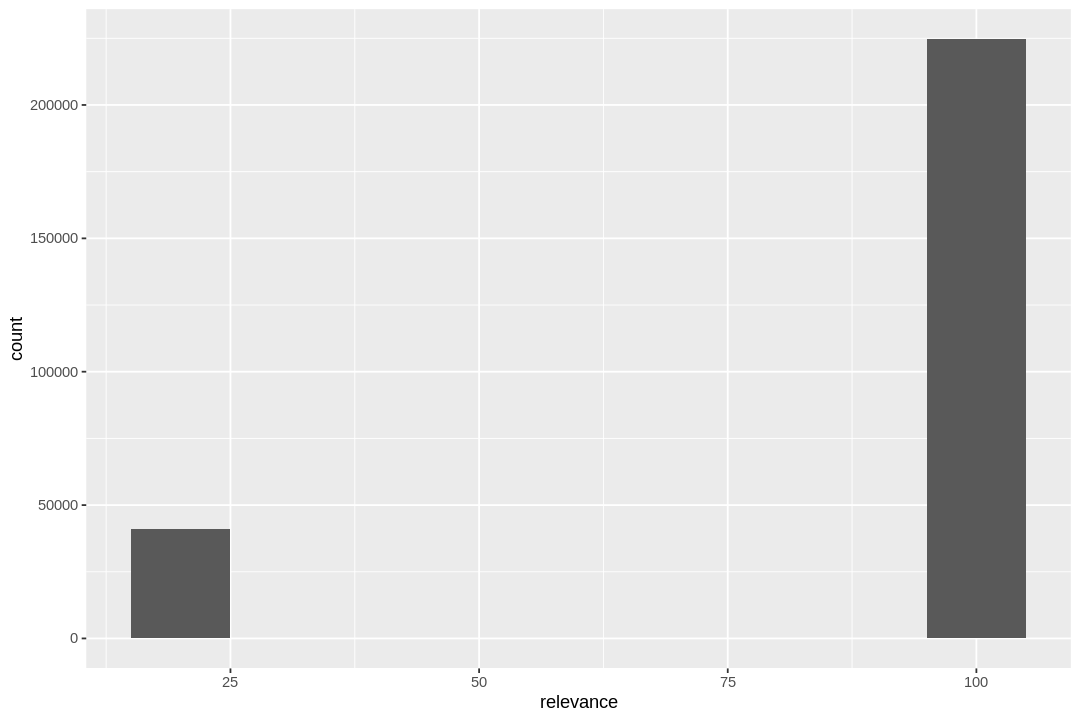

In [ ]:
# Plotting relative frequency of $ess
# It is striking that the data is essentially categorical

rp.dj.2021 %>%
  ggplot() +
  geom_histogram(aes(x = relevance), binwidth = 10)

In [ ]:
# Assess the prevelance across various stocks
# Very high concentration of prevelance = 20 within a small number of stocks

rp.dj.2021 %>%
  filter(relevance == 20) %>%
  tabyl(rp_entity_id) %>%
  adorn_pct_formatting(digits = 2, affix_sign = TRUE) %>%
  arrange(desc(n)) %>%
  head(10)

,rp_entity_id,n,percent
,<chr>,<dbl>,<chr>
1,CFF97C,8494,20.62%
2,9196A2,6849,16.62%
3,3461CF,6038,14.65%
4,B3CB74,5185,12.58%
5,1E1125,2918,7.08%
6,619882,2468,5.99%
7,58CA9A,2139,5.19%
8,E8846E,1737,4.22%
9,50070E,1592,3.86%


In [ ]:
# Assess the trend where relevance = 20 is heavily concentrated across a few stocks
#
# Conclusion:
# 4. Relevance = 20 should be eliminiated as they largely pertain to their role
# in publishing credit rating or price target changes

# Top 5 stocks
curious = c("CFF97C", "9196A2", "3461CF", "B3CB74", "1E1125")
rp.company.index %>%
  filter(rp_entity_id %in% curious)

# Top categories
rp.dj.2021 %>%
  filter(relevance == 20) %>%
  tabyl(category) %>%
  adorn_pct_formatting(digits = 2, affix_sign = TRUE) %>%
  arrange(desc(n)) %>%
  head(5)

X,rp_entity_id,entity_type,entity_name,ticker,cusip,isin,country
<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
19746,1E1125,COMP,Credit Suisse Group AG,CSR,225401108,US2254011081,US
32754,3461CF,COMP,Moody's Corp.,MCO,615369105,US6153691059,US
89182,9196A2,COMP,Morgan Stanley & Co. LLC,MS,617446448,US6174464486,US
108932,B3CB74,COMP,Raymond James Financial Inc.,RJF,754730109,US7547301090,US
126416,CFF97C,COMP,S&P Global Inc.,SPGI,78409V104,US78409V1044,US


,category,n,percent
,<chr>,<dbl>,<chr>
1,analyst-ratings-change-neutral-rater,8221,19.95%
2,price-target-upgrade-rater,7846,19.04%
3,credit-rating-action-rater,3914,9.50%
4,price-target-downgrade-rater,2866,6.96%
5,credit-rating-set-rater,2671,6.48%


## Data Processing

In [ ]:
# Load Dow Jones data for 2019, 2020, 2021

rp.dj.2019 = read.csv(rp.dj.2019.path)
rp.dj.2019$rpna_date_utc = mdy(rp.dj.2019$rpna_date_utc)

rp.dj.2020 = read.csv(rp.dj.2020.path)
rp.dj.2020$rpna_date_utc = mdy(rp.dj.2020$rpna_date_utc)

rp.dj.2021 = read.csv(rp.dj.2021.path)
rp.dj.2021$rpna_date_utc = mdy(rp.dj.2021$rpna_date_utc)

# Load Press Release data for 2019, 2020, 2021

rp.pr.2019 = read.csv(rp.pr.2019.path)
rp.pr.2019$rpna_date_utc = mdy(rp.pr.2019$rpna_date_utc)

rp.pr.2020 = read.csv(rp.pr.2020.path)
rp.pr.2020$rpna_date_utc = mdy(rp.pr.2020$rpna_date_utc)

rp.pr.2021 = read.csv(rp.pr.2021.path)
rp.pr.2021$rpna_date_utc = mdy(rp.pr.2021$rpna_date_utc)

In [106]:
faang = read.csv(RP.path)
head(faang,20)

,RP_ENTITY_ID,RELEVANCE,ESS,RPNA_DATE_UTC
,<chr>,<int>,<int>,<int>
1,0157B1,100,63,20119
2,0157B1,100,11,40119
3,0157B1,100,63,40119
4,0157B1,100,61,70119
5,0157B1,100,61,70119
6,0157B1,100,61,70119
7,0157B1,100,64,70119
8,0157B1,100,64,70119
9,0157B1,100,63,70119


In [107]:
faang$RPNA_DATE_UTC = dmy(faang$RPNA_DATE_UTC)
head(faang,20)

,RP_ENTITY_ID,RELEVANCE,ESS,RPNA_DATE_UTC
,<chr>,<int>,<int>,<date>
1,0157B1,100,63,2019-01-02
2,0157B1,100,11,2019-01-04
3,0157B1,100,63,2019-01-04
4,0157B1,100,61,2019-01-07
5,0157B1,100,61,2019-01-07
6,0157B1,100,61,2019-01-07
7,0157B1,100,64,2019-01-07
8,0157B1,100,64,2019-01-07
9,0157B1,100,63,2019-01-07


In [118]:
tickers = list("AAPL", "AMZN", "FB", "GOOGL", "NFLX")

faang %>% rename(date = RPNA_DATE_UTC, rp_entity_id = RP_ENTITY_ID) %>%
          left_join(y = rp.company.index,
                by = "rp_entity_id") %>%
          filter(ticker %in% tickers) %>%
          select(ticker, date, ESS) %>%
          group_by(date, ticker) %>% # Treat $rpna_date_utc and $rp_entity_id as a combination
            summarize(newssentiment = mean(ESS, na.rm = TRUE), # Take simple mean of ess for each combination
                      newsmentions = n()) %>% 
            ungroup() %>%
            group_by(ticker) %>%
            pad(start_val = as.Date("2019-01-01"), end_val = as.Date("2021-08-30")) %>%
            replace_na(list(newsmentions = 0, newssentiment = 50)) %>%
            write.csv("news.csv", row.names = FALSE)

`summarise()` has grouped output by 'date'. You can override using the `.groups` argument.

pad applied on the interval: day



In [ ]:
tickers = list("AAPL", "AMZN", "FB", "NFLX", "GOOGL")

rp = rbind(rp.dj.2019, rp.dj.2020, rp.dj.2021, rp.pr.2019, rp.pr.2020, rp.pr.2021) %>%
      rename(date = rpna_date_utc) %>%
      filter(relevance == 100,
            date >= as.Date("2019-01-01") & date <= as.Date("2021-08-30")) %>% 
      left_join(y = rp.company.index,
                by = "rp_entity_id") %>% # Replace $rp_entity_id with $ticker
      filter(ticker %in% tickers) %>%
      select(ticker, date, ess) # Retain relevant rows 

In [ ]:
rp.impute = rp %>%
            group_by(date, ticker) %>% # Treat $rpna_date_utc and $rp_entity_id as a combination
            summarize(newssentiment = mean(ess, na.rm = TRUE), # Take simple mean of ess for each combination
                      newsmentions = n()) %>% 
            ungroup() %>%
            group_by(ticker) %>%
            pad(start_val = as.Date("2019-01-01"), end_val = as.Date("2021-08-30")) %>%
            replace_na(list(newsmentions = 0, newssentiment = 50)) %>%
            write.csv("news.csv", row.names = FALSE)

`summarise()` has grouped output by 'date'. You can override using the `.groups` argument.

pad applied on the interval: day



# **Twitter Follower Data**

*   Choose between absolute follower numbers or % change, depends on method
*   Weekend data needs to be handled





In [ ]:
twitter.follower = read.csv(twitter.follower.path)
# Convert to datetime format
twitter.follower$Date <- ymd(twitter.follower$Date)

In [ ]:
# Data available for 1411/2958 stocks
length(unique(twitter.follower$Ticker))

first = min(twitter.follower$Date)
last = max(twitter.follower$Date)
last - first
paste(first, ",", last)

[1] 1411

Time difference of 530 days

[1] "2020-05-02 , 2021-10-14"

In [ ]:
str(twitter.follower)

'data.frame':	612219 obs. of  6 variables:
 $ Date            : Date, format: "2021-10-14" "2021-10-13" ...
 $ Ticker          : chr  "A" "A" "A" "A" ...
 $ Followers       : num  28378 28378 28374 28373 28370 ...
 $ pct_change_day  : num  0 0.0141 0.00352 0.01057 0.0141 ...
 $ pct_change_week : num  0.0811 0.067 0.0988 0.1129 0.1059 ...
 $ pct_change_month: num  0.45 0.467 0.467 0.46 0.482 ...


In [ ]:
# Different stocks haev data available over different periods
# Reasonable to choose those with at least 431

twitter.follower %>%
  group_by(Ticker) %>%
  summarise(count = n()) %>%
  ungroup() %>%
  group_by(count) %>%
  summarise (freq = n()) %>%
  arrange(desc(freq)) %>%
  head(10)

count,freq
<int>,<int>
443,914
438,226
442,156
437,37
439,10
441,6
431,3
440,3
448,3


In [ ]:
# Take stocks with min 431 days
min431days = twitter.follower %>%
              group_by(Ticker) %>%
              summarise(count = n()) %>%
              filter(count >= 431) %>%
              ungroup() %>%
              distinct(Ticker)

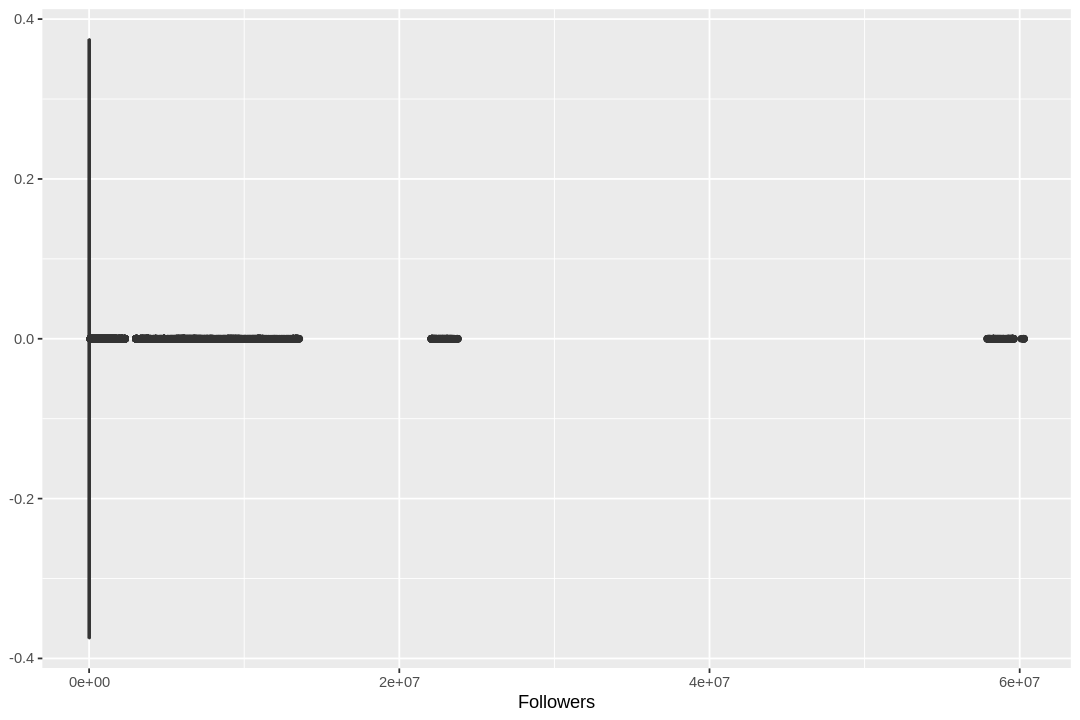

In [ ]:
# Followe count spans 7 orders of magnitude
twitter.follower %>%
  ggplot() +
  geom_boxplot(aes(x = Followers))

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



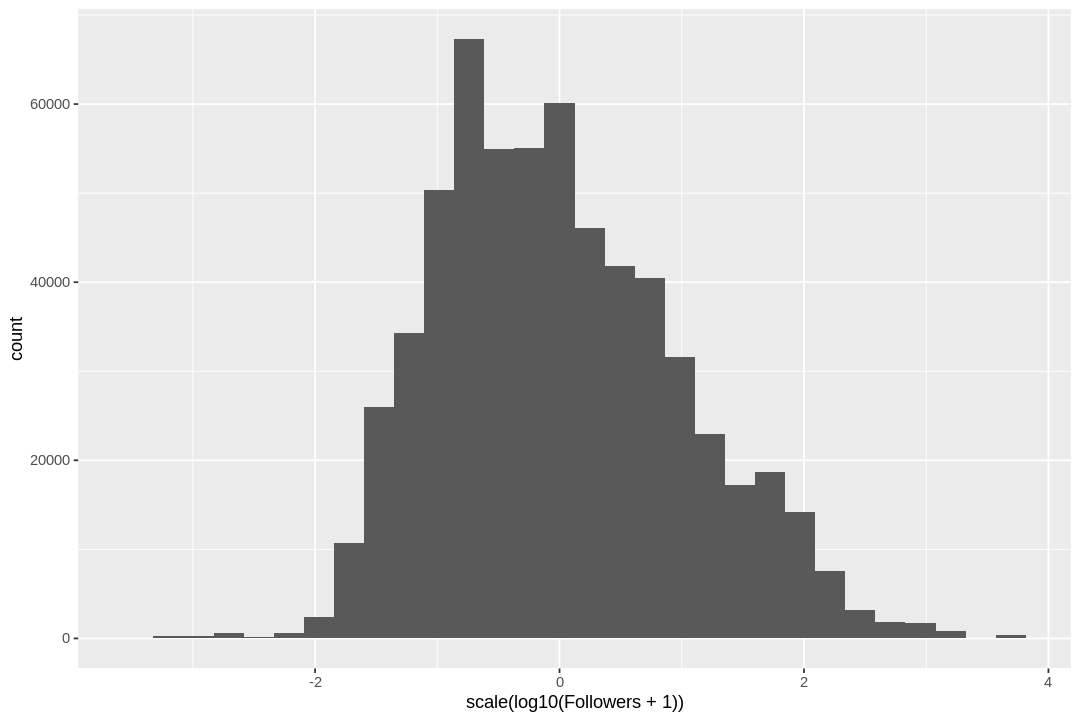

In [ ]:
# Scaling of log10 transformed $Followers is bettwe controlled
twitter.follower %>%
  ggplot() +
  geom_histogram(aes(x = scale(log10(Followers + 1))))

In [ ]:
# Using the $Ticker with sufficient data (more than 431 days)
# Determine which dates have missing data
#
# However, it is clear that missing data is distributed all over.
# Considering that missing density is not significant, it can be
# handled by imputing with immediately previous value

twitter.imputed = twitter.follower %>%
                    select(Date, Ticker, Followers) %>%
                    filter(Ticker %in% min431days$Ticker,
                          Date >= as.Date("2020-05-13")) %>%
                    pad(start_val = as.Date("2020-05-13"),
                        end_val = as.Date("2021-10-04"),
                        group = "Ticker") %>%
                    filter(!is.na(Ticker)) %>%
                    fill(Followers, .direction = "down") %>%
                    mutate(log10Followers = scale(log10(Followers + 1))) %>%
                    write.csv("twitter_imputed.csv", row.names = FALSE)

pad applied on the interval: day



# **r/wsb Data**


*   High degree of missingness for individual stocks (Missing not at random)
*Need imputation prior to analysis



In [ ]:
wsb.sentiment = read.csv(wsb.sentiment.path)
wsb.sentiment$Date <- mdy(wsb.sentiment$Date)

In [ ]:
first = min(wsb.sentiment$Date)
last = max(wsb.sentiment$Date)
last - first
paste(first, ",", last)

Time difference of 1177 days

[1] "2018-08-01 , 2021-10-21"

In [ ]:
head(wsb.sentiment, 10)

,Date,Ticker,Mentions,Rank,Sentiment
,<date>,<chr>,<int>,<int>,<dbl>
1,2018-08-10,AA,1,53,-0.4019
2,2018-08-28,AA,1,60,0.2023
3,2018-09-07,AA,1,74,0.7184
4,2018-10-09,AA,1,84,-0.2732
5,2018-10-18,AA,1,90,-0.0516
6,2018-11-03,AA,2,36,-0.0772
7,2018-11-28,AA,1,119,-0.5267
8,2019-01-04,AA,1,144,-0.5859
9,2019-01-08,AA,1,105,0.2732


[1] 1251

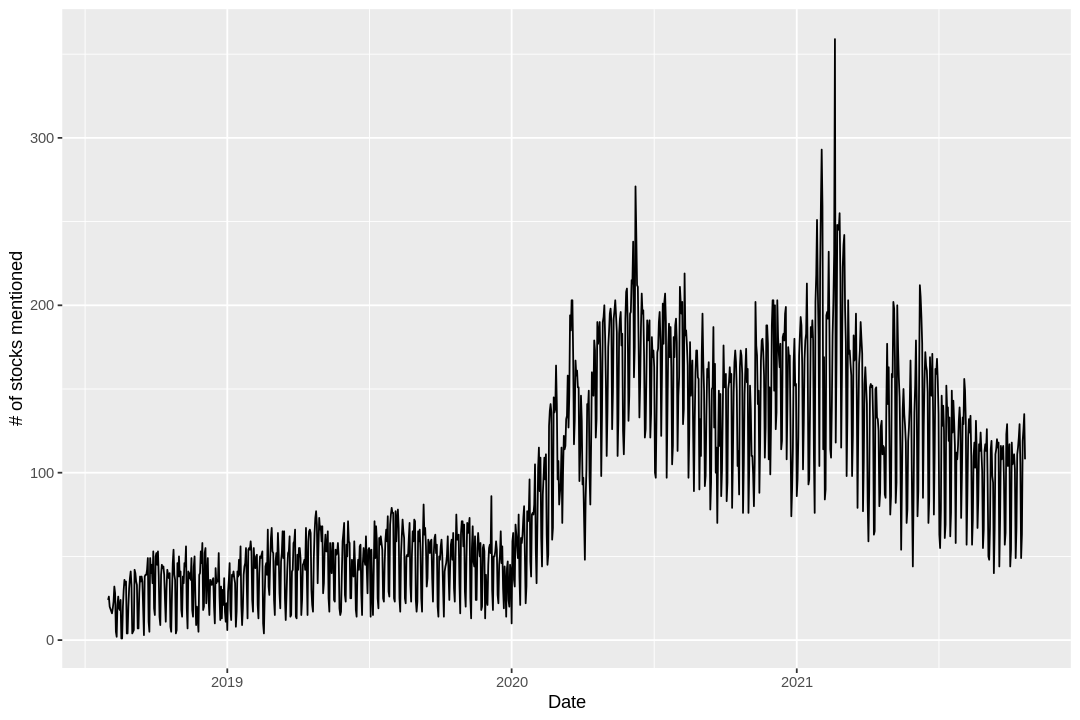

In [ ]:
# Sharp rise in stocks mentioned on r/wsb from Q2 2020
# Even though 1251 stocks are mentioned at some point
# No more than 200 stocks are mentioned daily on average

length(unique(wsb.sentiment$Ticker))

wsb.sentiment %>%
  tabyl(Date) %>%
  arrange(desc(n)) %>%
  ggplot(aes(x = Date, y = n)) +
  geom_line() +
  ylab("# of stocks mentioned")

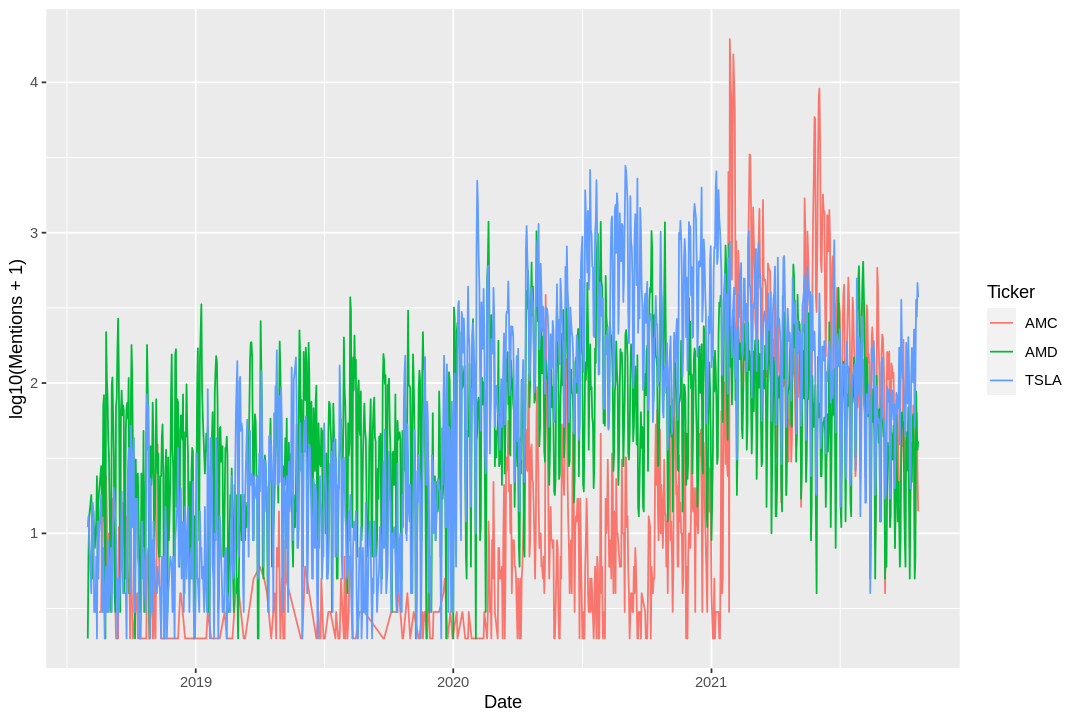

In [ ]:
# Plot data for a subset of r/wsb favourite stocks in log10
# 
# Conclusion:
# 
# 1. In the Q2 2020, mentions for such stocks increased by 2-4 orders of magnitude

meme = c("TSLA", "AMC", "AMD")
wsb.sentiment %>%
  filter(Ticker %in% meme) %>%
  ggplot() +
  geom_line(aes(x = Date, y = log10(Mentions + 1), colour  = Ticker))

##Pre-preparation

In [ ]:
wsb.impute = wsb.sentiment %>%
            rename(date = Date,
                  ticker = Ticker) %>%
            filter(ticker %in% tickers) %>%
            group_by(date, ticker) %>%
            summarize(wsbsentiment = mean(Sentiment, na.rm = TRUE), # Take simple mean of ess for each combination
                      wsbmentions = n()) %>%
            ungroup() %>%
            group_by(ticker) %>%
            filter(date >= as.Date("2019-01-01") & date <= as.Date("2021-08-30")) %>%
            pad(start_val = as.Date("2019-01-01"), end_val = as.Date("2021-08-30")) %>%
            replace_na(list(wsbmentions = 0, wsbsentiment = 0)) %>%
            write.csv("wsb.csv", row.names = FALSE)

`summarise()` has grouped output by 'date'. You can override using the `.groups` argument.

pad applied on the interval: day



# **Wikipedia pageviews**


*   Omitted from consideration due to weekly nature of data



In [ ]:
wiki.pageviews = read.csv(wiki.pageviews.path)
wiki.pageviews$Date <- ymd(wiki.pageviews$Date)

In [ ]:
head(wiki.pageviews, 10)

,Date,Ticker,Views,pct_change_week,pct_change_month
,<date>,<chr>,<dbl>,<dbl>,<dbl>
1,2016-10-17,A,66,-34.848485,-31.818182
2,2016-10-24,A,43,-34.848485,-31.818182
3,2016-10-31,A,52,20.930233,-31.818182
4,2016-11-07,A,47,-9.615385,-31.818182
5,2016-11-14,A,45,-4.255319,-31.818182
6,2016-11-21,A,44,-2.222222,2.325581
7,2016-11-28,A,36,-18.181818,-30.769231
8,2016-12-05,A,54,50.000000,14.893617
9,2016-12-12,A,55,1.851852,22.222222


In [ ]:
first = min(wiki.pageviews$Date)
last = max(wiki.pageviews$Date)
last - first
paste(first, ",", last)
length(unique(wiki.pageviews$Ticker))

Time difference of 1820 days

[1] "2016-10-17 , 2021-10-11"

[1] 954

# **Stock Price History**

In [ ]:
crsp.permnocode = read.csv(crsp.permnocode.path)
crsp.price.2019 = read.csv(crsp.price.2019.path)
crsp.price.2019$date <- dmy(crsp.price.2019$date)

In [ ]:
crsp.price.2019 %>%
left_join(x = crsp.price.2019,
          y = crsp.permnocode,
          by = c("PERMNO")) %>%
write.csv("crsp_price_2019.csv", row.names = FALSE)

In [ ]:
str(crsp.permnocode)

'data.frame':	3552 obs. of  2 variables:
 $ PERMNO: int  10026 10028 10032 10051 10104 10107 10138 10145 10158 10201 ...
 $ ticker: chr  "JJSF" "ELA" "PLXS" "HNGR" ...


In [ ]:
str(crsp.price.2020)

'data.frame':	728211 obs. of  11 variables:
 $ PERMNO : int  10026 10026 10026 10026 10026 10026 10026 10026 10026 10026 ...
 $ date   : Date, format: "2020-01-02" "2020-01-03" ...
 $ CUSIP  : chr  "46603210" "46603210" "46603210" "46603210" ...
 $ BIDLO  : num  181 181 183 182 182 ...
 $ ASKHI  : num  185 185 186 185 184 ...
 $ PRC    : num  182 185 185 183 182 ...
 $ VOL    : int  88291 71463 70308 72267 118592 55169 81532 65342 103802 92851 ...
 $ BID    : num  182 185 185 183 182 ...
 $ ASK    : num  182 185 185 183 182 ...
 $ OPENPRC: num  185 181 184 184 183 ...
 $ NUMTRD : num  2300 1572 1764 2032 2208 ...


In [ ]:
twtr.permno = crsp.permnocode %>% 
filter(htsymbol == "TWTR") 

twtr.permno

permno,htsymbol
<int>,<chr>
14295,TWTR
86298,TWTR


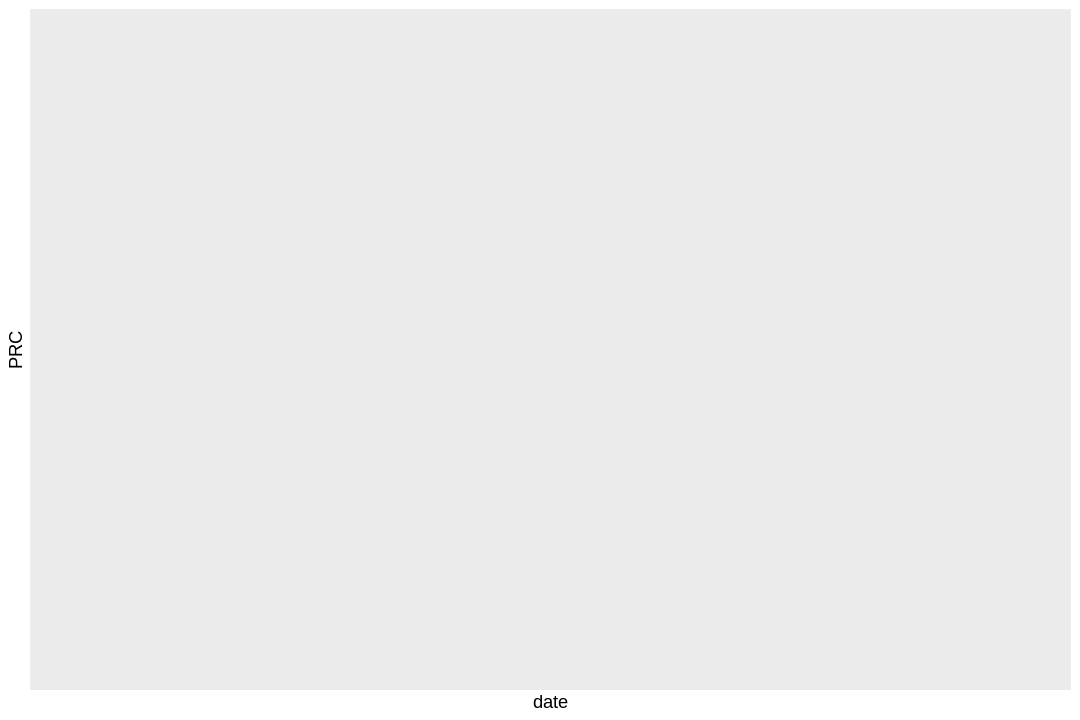

In [ ]:
crsp.price.2020 %>%
filter(PERMNO == c(86298)) %>%
ggplot() + geom_line(aes(x = date, y = PRC))

In [ ]:
head(crsp.price.2019, 5)

,PERMNO,date,CUSIP,BIDLO,ASKHI,PRC,VOL,BID,ASK,OPENPRC,NUMTRD
,<int>,<date>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<int>
1,10026,2019-01-02,46603210,139.1200,144.0400,141.00,112825,140.76,141.00,143.42,1648
2,10026,2019-01-03,46603210,140.2700,145.9100,143.02,84331,143.02,143.45,140.60,1272
3,10026,2019-01-04,46603210,143.1648,147.3650,144.84,88233,144.84,145.06,144.19,1068
4,10026,2019-01-07,46603210,142.8300,147.8700,145.41,79539,145.20,145.41,144.37,1276
5,10026,2019-01-08,46603210,145.5000,149.3023,148.70,70200,148.28,148.70,146.15,923


In [ ]:
aapl.permno = crsp.permnocode$permno[crsp.permnocode$htsymbol == "AAPL"]
aapl.permno

[1] 14593

In [ ]:
x_crsp = crsp.price.2019 %>%
filter(PERMNO == aapl.permno) %>%
select(date, VOL) %>%
head(15) %>%
rename(CRSP_Vol = VOL)

In [ ]:
full_join(x_crsp, x_otc, by = "date") %>%
select(date, Ticker, CRSP_Vol, OTC_Total_Vol) 

date,Ticker,CRSP_Vol,OTC_Total_Vol
<date>,<chr>,<int>,<int>
2019-01-02,AAPL,37066356,30912844
2019-01-03,AAPL,91373695,101236612
2019-01-04,AAPL,58603001,57093304
2019-01-07,AAPL,54770364,55734368
2019-01-08,AAPL,41026062,62425344
2019-01-09,AAPL,45098881,47573720
2019-01-10,AAPL,35778275,34545212
2019-01-11,AAPL,27017204,25274412
2019-01-14,AAPL,32468877,41930900


# **Twitter Data**

In [ ]:
git.path = "https://raw.githubusercontent.com/limshaocong/analyticsEdge/main/Datasets/"
twitter.sa.path1 = "Tweet_Analysis_Tagged/"
twitter.sa.path2 = "_tweets_2020_tagged.csv"

get.twitter.sa <- function (ticker){
  path = paste0(git.path, twitter.sa.path1, ticker, twitter.sa.path2)
  
  df = read.csv(path) %>%
    mutate(date = ymd(Date)) %>%
    pad(start_val = as.Date('2020-01-01'), end_val = as.Date('2020-12-31')) %>%
    select(date, Sentiment) %>%
    tabyl(date, Sentiment) %>%
    rowwise() %>%
    mutate(mentions = sum(c(negative, neutral, positive))) %>%
    mutate(twtrsentiment = (-negative + positive)/mentions) %>%
    mutate(ticker = ticker) %>%
    select(ticker, date, mentions, twtrsentiment)
}

In [ ]:
git.path = "https://raw.githubusercontent.com/limshaocong/analyticsEdge/main/Datasets/"
twitter.sa.path1 = "Tweet_Analysis_Tagged/"
twitter.sa.path2 = "_tweets_2019_tagged.csv"
twitter.sa.path3 = "_tweets_2020_tagged.csv"
twitter.sa.path4 = "_tweets_2021_tagged.csv"

get.twitter.sa <- function (tick){
  path2 = paste0(git.path, twitter.sa.path1, tick, twitter.sa.path2)
  path3 = paste0(git.path, twitter.sa.path1, tick, twitter.sa.path3)
  path4 = paste0(git.path, twitter.sa.path1, tick, twitter.sa.path4)

  df19 = read.csv(path2)
  df20 = read.csv(path3)
  df21 = read.csv(path4)

  df = rbind(df19, df20, df21) %>% 
        mutate(date = ymd(Date)) %>%
        pad(start_val = as.Date('2019-01-01'), end_val = as.Date('2021-08-30')) %>%
        select(date, Sentiment) %>%
        tabyl(date, Sentiment) %>%
        rowwise() %>%
        mutate(twtrmentions = sum(c(negative, neutral, positive))) %>%
        mutate(twtrsentiment = (-negative + positive)/twtrmentions) %>%
        mutate(ticker = tick) %>%
        select(ticker, date, twtrmentions, twtrsentiment)
}


In [ ]:
aapl = get.twitter.sa("AAPL")
googl = get.twitter.sa("GOOGL")
amzn = get.twitter.sa("AMZN")
fb = get.twitter.sa("FB")
nflx = get.twitter.sa("NFLX")

pad applied on the interval: day

pad applied on the interval: day

pad applied on the interval: day

pad applied on the interval: day

pad applied on the interval: day



In [ ]:
twtr = rbind(aapl, googl, amzn, fb, nflx)

twtr %>% group_by(ticker) %>% summarise(n())

twtr %>% write.csv("twtr.csv", row.names = FALSE)

ticker,n()
<chr>,<int>
AAPL,973
AMZN,973
FB,973
GOOGL,973
NFLX,973
